## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Захватаев Михаил Дмитриевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

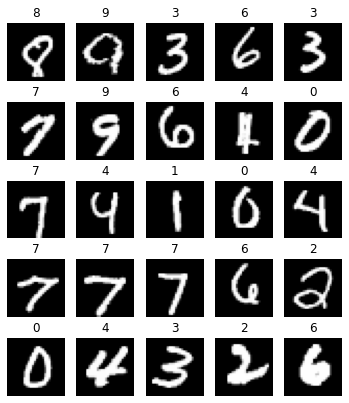

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0.0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [7]:
def check(mean, std, activation=nn.Tanh()):
    
    layers = []
    sizes = [28*28] + [500]*10 + [10]

    for size_input, size_output in zip(sizes, sizes[1:]):

        layer = nn.Linear(size_input, size_output)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        
        init_layer(layer, mean, std(size_input, size_output))
        
        layers.append(layer)
        layers.append(activation)
        
    del layers[-1]
    
    network = nn.Sequential(*layers)

    n_objects = 100
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data

    activations = network(X)
    loss = loss_fn(activations, y)
    print('\n')
    loss.backward()

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
def Normal(size_input, size_output):
    return 0.1

In [9]:
check(0, Normal, nn.Tanh())

forward 1.0013885498046875
forward 0.8454712629318237
forward 0.7880444526672363
forward 0.7737643122673035
forward 0.7695755958557129
forward 0.7682179808616638
forward 0.7661367654800415
forward 0.7598823308944702
forward 0.7618275880813599
forward 0.7621976137161255
forward 0.7622709274291992


backward 0.031269434839487076
backward 0.01424847636371851
backward 0.013784999027848244
backward 0.013911145739257336
backward 0.014518143609166145
backward 0.015685202553868294
backward 0.016133319586515427
backward 0.01875435747206211
backward 0.021717756986618042
backward 0.023620981723070145
backward 0.024895500391721725


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
def He(size_input, size_output):
    return np.sqrt(2/size_output)

In [11]:
def Xavier(size_input, size_output):
    return np.sqrt(2/(size_input+size_output))

In [13]:
check(0, He, nn.Tanh())

forward 1.0013885498046875
forward 0.7683477401733398
forward 0.6539520621299744
forward 0.6029569506645203
forward 0.582649290561676
forward 0.5668461918830872
forward 0.5594420433044434
forward 0.557776927947998
forward 0.556174635887146
forward 0.5509766340255737
forward 0.5531386733055115


backward 0.031269434839487076
backward 0.10751678049564362
backward 0.10612764209508896
backward 0.09895728528499603
backward 0.10202441364526749
backward 0.10149972885847092
backward 0.10249050706624985
backward 0.0984257385134697
backward 0.0868690088391304
backward 0.07513094693422318
backward 0.047352951020002365


In [102]:
check(0, Xavier, nn.Tanh())

forward 1.00098717212677
forward 0.6468866467475891
forward 0.49425262212753296
forward 0.4155466556549072
forward 0.36063703894615173
forward 0.3215141296386719
forward 0.28984400629997253
forward 0.26856088638305664
forward 0.25134527683258057
forward 0.23837421834468842
forward 0.22460463643074036


backward 0.027888666838407516
backward 0.018927697092294693
backward 0.018282661214470863
backward 0.017100507393479347
backward 0.016138477250933647
backward 0.015192391350865364
backward 0.013538433238863945
backward 0.011277555488049984
backward 0.009454705752432346
backward 0.006917631719261408
backward 0.0042580184526741505


In [21]:
# He с ReLU
check(0, He, nn.ReLU())

forward 1.0013885498046875
forward 1.0588692426681519
forward 1.0106209516525269
forward 1.0129293203353882
forward 1.0418827533721924
forward 1.064301609992981
forward 1.1801495552062988
forward 1.2513689994812012
forward 1.2429287433624268
forward 1.2351619005203247
forward 1.197290062904358


backward 0.031269434839487076
backward 0.09779707342386246
backward 0.0822543203830719
backward 0.07465597987174988
backward 0.07090231776237488
backward 0.06744111329317093
backward 0.06527914106845856
backward 0.05433841049671173
backward 0.04898133501410484
backward 0.04424485191702843
backward 0.04255305230617523


<i> 1.4 Сделайте выводы по первой части </i>

- Xavier показывает лучшие результаты
- Инициализация He с ReLU показывает хороший результат, т.к. положительная область ReLU линейна

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [103]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.zeros(self.linear.weight.shape, requires_grad=False)
        
        if self.training:
            mask = mask.bernoulli_(self.p)
        else:
            mask += self.p

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:   

1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [22]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 9... (Train/Test) NLL: 0.149/0.085	Accuracy: 0.956/0.972


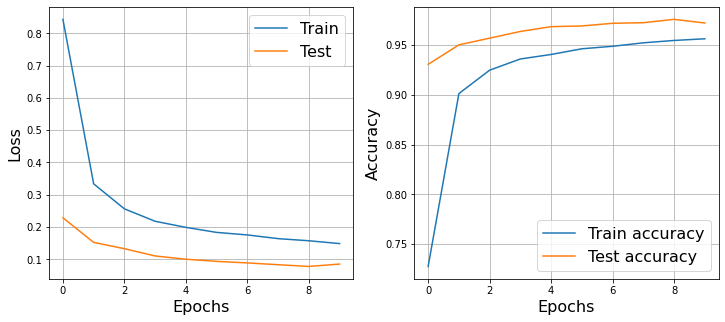

([0.8433567930513354,
  0.33386715588920407,
  0.2563582191716379,
  0.21786245887975958,
  0.19901159027619147,
  0.18338476910170462,
  0.1755309799062545,
  0.16405857556156003,
  0.15750649163146008,
  0.14874406992150013],
 [0.22874765286717233,
  0.1524769417187081,
  0.13287938522953022,
  0.11040493706830695,
  0.1002943427007221,
  0.09361182635390683,
  0.0888787187588743,
  0.08335162363239104,
  0.07794037708847583,
  0.08527811909023719],
 [0.72772855,
  0.9013082,
  0.9248401,
  0.9360841,
  0.94060946,
  0.9463175,
  0.9488384,
  0.9523088,
  0.9546797,
  0.9563621],
 [0.9306764,
  0.9502571,
  0.9569818,
  0.9637065,
  0.96855223,
  0.9692445,
  0.9719145,
  0.9725079,
  0.97587025,
  0.97221124])

In [106]:
from train_utils import train

layers = [nn.Linear(196, 128),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(128,128),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.139/0.072	Accuracy: 0.957/0.977


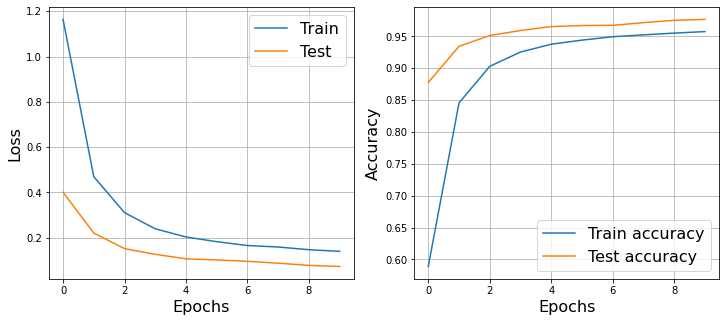

([1.1643860835764708,
  0.4690607231753721,
  0.31017801791493066,
  0.2386530759269749,
  0.20261420477936262,
  0.18183166923712313,
  0.16476114172893547,
  0.15826435856568788,
  0.1463301107128546,
  0.1391264986373913],
 [0.40027134686331206,
  0.2198548475398293,
  0.1510190597346312,
  0.1259745017778647,
  0.10606414277719546,
  0.1011225541086891,
  0.09498947585308098,
  0.08675094563042439,
  0.07702009938657284,
  0.07237485477913029],
 [0.58904135,
  0.84560454,
  0.9030017,
  0.925362,
  0.93766105,
  0.9440798,
  0.9494048,
  0.9523199,
  0.9550795,
  0.95746154],
 [0.8776701,
  0.9343355,
  0.9513449,
  0.9591574,
  0.96528876,
  0.9669699,
  0.9672666,
  0.971519,
  0.975178,
  0.9766614])

In [108]:
from train_utils import train

# По умолчанию p=0.5

layers = [DropConnect(196, 128),
          nn.ReLU(),
          DropConnect(128,128),
          nn.ReLU(),
          DropConnect(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Dropout и DropConnect уменьшают переобучение, test превосходит train

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [25]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(dim=1).view(-1, 1)
        std = x.std(dim=1).view(-1, 1)
        output = (x - mean)/((std+self.eps)**2)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
    
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.020/0.056	Accuracy: 0.994/0.984


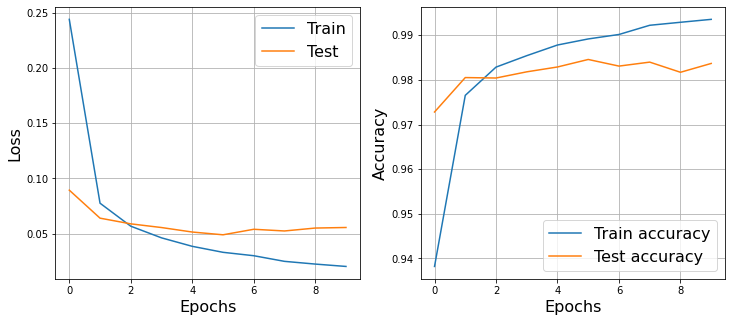

([0.24392279810202655,
  0.07751337866157865,
  0.056691171171497114,
  0.04614543910525533,
  0.038474592803193056,
  0.03305612917669785,
  0.029976272052511382,
  0.02487558800193952,
  0.022408239279331554,
  0.02026358635268057],
 [0.08931974066963679,
  0.06396841027337728,
  0.05881758440946099,
  0.05547658781980789,
  0.05141187487523767,
  0.04891146488706552,
  0.05390848357324736,
  0.05237663161492895,
  0.055016092095476914,
  0.05552111138719358],
 [0.9382107,
  0.9765347,
  0.98285913,
  0.98542446,
  0.98781204,
  0.98917246,
  0.9901719,
  0.99223197,
  0.99290377,
  0.99355894],
 [0.9728046,
  0.9805182,
  0.9804193,
  0.9818038,
  0.9828916,
  0.98457277,
  0.9830894,
  0.9839794,
  0.9817049,
  0.98368275])

In [23]:
from train_utils import train

layers = [nn.Linear(196, 128),
          nn.BatchNorm1d(128, affine=False),
          nn.ReLU(),
          nn.Linear(128,128),
          nn.BatchNorm1d(128, affine=False),
          nn.ReLU(),
          nn.Linear(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.037/0.062	Accuracy: 0.988/0.981


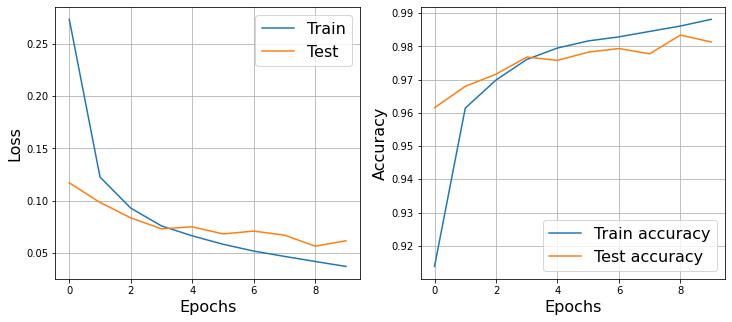

([0.2733024227768501,
  0.12262776908256225,
  0.09294141626267481,
  0.07592869113121968,
  0.06646077406914361,
  0.0584453560396044,
  0.05192025910927924,
  0.04683048357424547,
  0.04197541738290395,
  0.037232224622231004],
 [0.11713053625595721,
  0.0983534253945079,
  0.08362367956698695,
  0.0731840864460491,
  0.07510929100828458,
  0.06832575449083425,
  0.070985848873948,
  0.06714126362783622,
  0.056582226417958736,
  0.06177937135666232],
 [0.9137793,
  0.96141505,
  0.96985495,
  0.9760461,
  0.9794943,
  0.9816209,
  0.982848,
  0.9844861,
  0.9861074,
  0.98811185],
 [0.96153086,
  0.96795887,
  0.9716179,
  0.97676027,
  0.97577137,
  0.97824365,
  0.9793315,
  0.9777492,
  0.9833861,
  0.98130935])

In [26]:
from train_utils import train

layers = [nn.Linear(196, 128),
          LayerNormalization(),
          nn.ReLU(),
          nn.Linear(128,128),
          LayerNormalization(),
          nn.ReLU(),
          nn.Linear(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

- Для данной архитектуры при батч нормализации сеть сходится быстрее
- Результаты в целом очень близки и превосходят предыдущие
- Разница между train/test при LayerNormalization меньше

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: